In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
from utils import *
import poissonimageediting as poisson
from tqdm.auto import tqdm
import torch
from pietorch_local.functional import blend, blend_wide
from pietorch_local.functional_numpy import blend_numpy
from torchvision.transforms import functional as TF
from PIL import Image
np.set_printoptions(threshold=sys.maxsize)

In [8]:
image = Image.open('data/target_image/215100.jpg').convert('RGB')
# image = np.array(image)[:, :, ::-1].copy()
image = np.array(image)
dataset_images_dir = "data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [9]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [10]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
# filter size that is too small
target_df_filtered = target_df
# target_df_filtered = target_df[target_df['size'] > 1000]
print(target_df_filtered.shape)

(1060, 13)


In [11]:
dataset_df.shape


(246480, 12)

In [12]:
def warp_and_paste_ellipse(source_image_path, destination_image_shape, source_params, destination_params):
    # Load the source and destination images
    source_image = Image.open(source_image_path).convert('RGB') # RGB
    source_image = np.array(source_image)
    
    # print(source_image.max(), source_image.min())

    # source_image = np.array(source_image)[:, :, ::-1].copy()
    # source_image = np.array(source_image)
    # source_image = cv2.imread(source_image_path)

    # Unpack ellipse parameters
    u, v, major_axis_length, minor_axis_length, angle = source_params
    u2, v2, major_axis_length2, minor_axis_length2, angle2 = destination_params

    # Define the source ellipse parameters (from the source image)
    center1 = (int(u), int(v))
    axes1 = (int(major_axis_length), int(minor_axis_length))
    angle1 = np.degrees(angle)

    # Define the destination ellipse parameters (on the destination image)
    center2 = (int(u2), int(v2))
    axes2 = (int(major_axis_length2), int(minor_axis_length2))
    angle2 = np.degrees(angle2)

    # Create a mask for the source ellipse
    mask = np.zeros_like(source_image)
    cv2.ellipse(mask, center1, axes1, angle1, 0, 360, (255, 255, 255), -1)

    # Extract the source ellipse region
    source_ellipse_region = cv2.bitwise_and(source_image, mask)

    # Define the bounding box around the source ellipse
    src_rect = cv2.boxPoints(((center1[0], center1[1]), (axes1[0] * 2, axes1[1] * 2), angle1))
    src_rect = np.int0(src_rect)

    # Define the bounding box around the destination ellipse
    dst_rect = cv2.boxPoints(((center2[0], center2[1]), (axes2[0] * 2, axes2[1] * 2), angle2))
    dst_rect = np.int0(dst_rect)

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(np.float32(src_rect), np.float32(dst_rect))

    # Warp the source ellipse region to the shape of the destination ellipse
    warped_ellipse_region = cv2.warpPerspective(source_ellipse_region, M, (destination_image_shape[1], destination_image_shape[0]))

    # Get the bounding box of the destination ellipse
    x, y, w, h = cv2.boundingRect(dst_rect)

    # Crop the warped source ellipse to its bounding box
    warped_source_ellipse_bbox = warped_ellipse_region[y:y+h, x:x+w]
    # color
    # if (warped_source_ellipse_bbox is not None):
        # warped_source_ellipse_bbox = cv2.cvtColor(warped_source_ellipse_bbox, cv2.COLOR_BGR2RGB)
    
    # get the top left corner points of the bounding box in the image
    corner = (x, y)
    
    return warped_source_ellipse_bbox, corner

In [16]:
canvas = Image.new('RGB', (image.shape[1], image.shape[0]), (0, 0, 0))
canvas = np.array(canvas).astype(np.float32)

print(canvas.dtype, canvas.shape)

# use enumerate to get the index of the row

# use enumerate and tqdm
for i, (index, row) in enumerate(tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0])):
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"

    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    ellipse, corner = warp_and_paste_ellipse(match_image_path, canvas.shape, source_params, destination_params)
    ellipse = ellipse.astype(float)

    if ellipse is not None and ellipse.shape[0] > 0 and ellipse.shape[1] > 0:
        # Get top-left corner coordinates
        x, y = corner
        
        # nd.array
        mask = (ellipse != 0).any(axis=2).astype(np.float32)
        # plt.imshow(mask)
        # plt.show()
        # canvas = canvas.astype(float)
        # plt.imshow(canvas)
        # plt.show()
        ellipse = ellipse.astype(np.float32)
        # plt.imshow(ellipse)
        # plt.show()

        corner_cood = np.array([y, x], dtype=np.int32)
        
        result = blend_numpy(canvas, ellipse, mask, corner_cood, mix_gradients=True, channels_dim=2)
        canvas = result

float32 (1920, 2560, 3)


  0%|          | 0/1060 [00:00<?, ?it/s]/tmp/ipykernel_1343197/799746616.py:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_1343197/799746616.py:39: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)
100%|██████████| 1060/1060 [01:31<00:00, 11.52it/s]


1.0 0.0


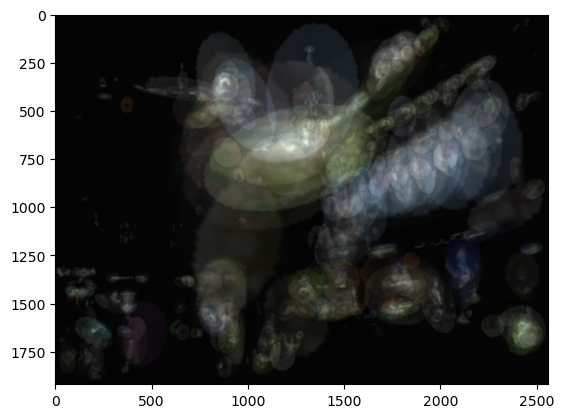

In [17]:
prev_canvas = canvas.copy() 
canvas_normalized = (prev_canvas - prev_canvas.min()) / (prev_canvas.max() - prev_canvas.min())
print(canvas_normalized.max(), canvas_normalized.min())

plt.imshow(canvas_normalized)
# plt.imsave('215100_output.jpg', canvas_out)

In [ ]:
canvas = Image.new('RGB', (image.shape[1], image.shape[0]), (0, 0, 0))
canvas = TF.to_tensor(canvas).float()

# use enumerate to get the index of the row

# use enumerate and tqdm
for i, (index, row) in enumerate(tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0])):
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"

    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    canvas_array = torch.moveaxis(canvas, 0, -1).numpy()
    ellipse, corner = warp_and_paste_ellipse(match_image_path, canvas_array, source_params, destination_params)
    ellipse = ellipse.astype(float)

    if ellipse is not None and ellipse.shape[0] > 0 and ellipse.shape[1] > 0:
        # Get top-left corner coordinates
        x, y = corner
        
        # # Check if there is overlap
        # canvas_region = canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]]
        
        # if np.count_nonzero(canvas_region) == 0:
        #     # No overlap, paste directly
        #     canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse
        # else:
        # tensor
        target = canvas
        source = TF.to_tensor(ellipse).float()
        mask = (source != 0).any(dim=0).float()
        
        # print(target.dtype, source.dtype, mask.dtype)
        corner_cood = torch.tensor([y, x])
        print(target.shape, source.shape, mask.shape, corner_cood.shape)
        result = blend(target, source, mask, corner_cood, True, channels_dim=0)
        # print('result shape', result.shape, canvas.shape)
        canvas = result
            
            # nd.array
            # mask = (ellipse != 0).any(axis=2).astype(float)
            # # plt.imshow(mask)
            # # plt.show()
            # # canvas = canvas.astype(float)
            # # plt.imshow(canvas)
            # # plt.show()
            # ellipse = ellipse.astype(float)
            # # plt.imshow(ellipse)
            # # plt.show()

            # corner_cood = np.array([y, x], dtype=np.int32)
            # print(canvas.max(), canvas.min())
            # print(ellipse.max(), ellipse.min())
            # print(mask.max(), mask.min())
            # canvas = blend_numpy(canvas, ellipse, mask, corner_cood, mix_gradients=True, channels_dim=2)
            
            # # print(canvas.max(), canvas.min())
            # print(canvas.dtype)
        # break
        # show_img(canvas)
        # plt.imshow(canvas/255)
        # plt.show()
        
        # if i > 3:
        #     break
        # canvas will be result numpy
        # canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse
        # save the canvas every iteration
        # cv2.imwrite(f'output/output{i:3d}.png', canvas)

tensor(1779.3627) tensor(-34.4335)


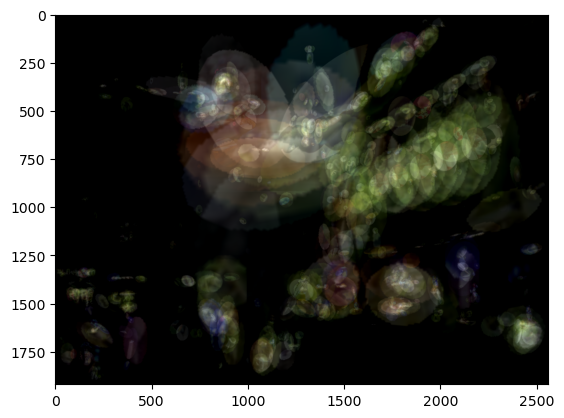

In [74]:
print(canvas.max(), canvas.min())
prev_canvas = torch.movedim(canvas, 0, -1)
prev_canvas = prev_canvas.clip(100, prev_canvas.max())
prev_canvas = (prev_canvas - prev_canvas.min()) / (prev_canvas.max() - prev_canvas.min())
plt.imshow(prev_canvas)


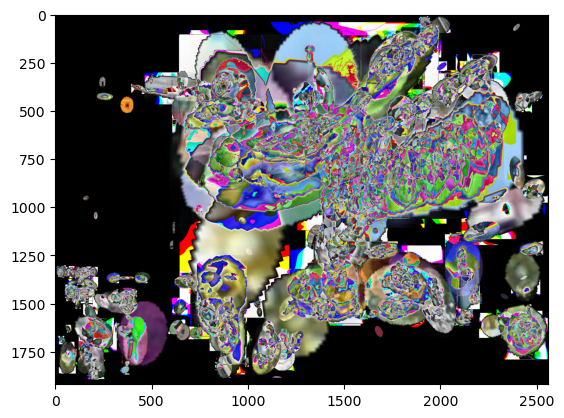

In [21]:
# canvas.shape, target.shape, source.shape, mask.shape, corner_cood
plt.imshow(mask)

(1920, 2560, 3)


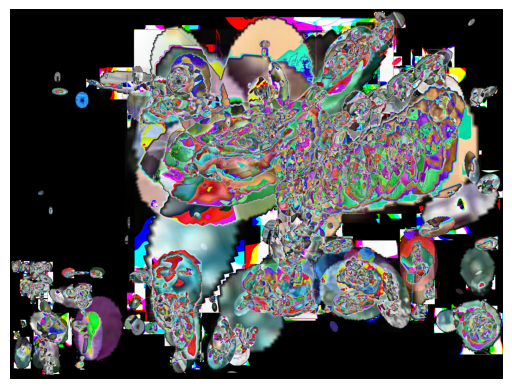

In [22]:
show_img(canvas)